In [1]:
import tensorflow as tf
import os
import glob
import cv2
import shutil
# import torchaudio
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
# import autokeras as ak
from keras.models import save_model
from moviepy.video.io.VideoFileClip import VideoFileClip
import librosa
from sklearn.model_selection import train_test_split
import h5py
import shutil

In [2]:
source_dir_real = '/kaggle/input/celeb-df-v2/Celeb-real'
source_dir_fake = '/kaggle/input/celeb-df-v2/Celeb-synthesis'
destination_dir_real = '/dataset/Real'
destination_dir_fake = '/dataset/Fake'
dataset_root = '/dataset'

In [3]:
def multimodal_fusion(images, num_modalities):
    num_samples, num_frames, height, width, channels = images.shape

    # Create additional modalities by converting images to grayscale
    additional_modalities = []
    for i in range(1, num_modalities):
        modified_images = []
        for frame in range(num_frames):
            grayscale_frame = np.mean(images[:, frame], axis=-1, keepdims=True)
            modified_images.append(grayscale_frame)
        additional_modalities.append(np.array(modified_images))

    # Tile the additional modalities to match the number of frames
    tiled_modalities = [modalities[:, np.newaxis] for modalities in additional_modalities]
    tiled_modalities = [np.tile(modalities, (1, num_frames, 1, 1, 1)) for modalities in tiled_modalities]

    # Concatenate the original images and additional modalities along the channel axis
    fused_data = np.concatenate((images, *tiled_modalities), axis=-1)
    return fused_data

In [4]:
batch_size = 40
num_modalities = 1 #Add GrayScale with RGB modality

# Load the data from the HDF5 file
h5_file = h5py.File('data.h5', 'r')
num_samples = len(h5_file['X_images_train'])
y_train = h5_file['y_train'][:]

multimodal_data = []

for batch_start in range(0, num_samples, batch_size):
    batch_end = min(batch_start + batch_size, num_samples)
    batch_X_images_train = h5_file['X_images_train'][batch_start:batch_end]
    #batch_X_images_test = h5_file['X_images_test'][batch_start:batch_end]

    # Perform multimodal fusion on the current batch
    fused_batch_X_train = multimodal_fusion(batch_X_images_train, num_modalities)
    #fused_batch_X_test = multimodal_fusion(batch_X_images_test, num_modalities)
    multimodal_data.append(fused_batch_X_train)
    print("Fused batch X_train shape:", fused_batch_X_train.shape)
    #print("Fused batch X_test shape:", fused_batch_X_test.shape)

h5_file.close()

Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)
Fused batch X_train shape: (40, 10, 64, 64, 3)


In [5]:
# Stack the multimodal data
fused_X_train = np.vstack(multimodal_data)

# Get the dimensions from the shape of fused_X_train
num_samples, num_frames, height, width, channels = fused_X_train.shape

# Reshape the data to match AutoKeras expected format
reshaped_X_train = fused_X_train.reshape((-1, height, width, channels))

# Reshape again to treat each frame as a separate sample
reshaped_X_train = reshaped_X_train.reshape((-1, height, width, channels))

# Reshape y_train to match the new number of samples
reshaped_y_train = np.repeat(y_train, num_frames, axis=0)

print("reshaped_X_train shape:", reshaped_X_train.shape)
print("reshaped_y_train shape:", reshaped_y_train.shape)

X_train, X_val, y_train, y_val = train_test_split(reshaped_X_train, reshaped_y_train, test_size=0.2, random_state=42)

reshaped_X_train shape: (1600, 64, 64, 3)
reshaped_y_train shape: (1600,)


**Save the best fit model and explore it**

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models


model = models.Sequential()
input_layer = tf.keras.Input(shape=(64, 64, 3))
cast_to_float32 = layers.Lambda(lambda x: tf.cast(x, tf.float32))(input_layer)
normalization = layers.Normalization()(cast_to_float32)
conv2d = layers.Conv2D(32, (3, 3), activation='relu')(normalization)
conv2d_1 = layers.Conv2D(64, (3, 3), activation='relu')(conv2d)
max_pooling2d = layers.MaxPooling2D((2, 2))(conv2d_1)
dropout = layers.Dropout(0.5)(max_pooling2d)
flatten = layers.Flatten()(dropout)
dropout_1 = layers.Dropout(0.5)(flatten)
dense = layers.Dense(1)(dropout_1)
classification_head_1 = layers.Activation('sigmoid')(dense)
model = tf.keras.Model(inputs=input_layer, outputs=classification_head_1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 64, 64, 3)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                           

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
32/32 [==============================] - 5s 23ms/step - loss: 4.4932 - accuracy: 0.6826 - val_loss: 0.3487 - val_accuracy: 0.8633
Epoch 2/20
32/32 [==============================] - 0s 14ms/step - loss: 0.3648 - accuracy: 0.8652 - val_loss: 0.1928 - val_accuracy: 0.9297
Epoch 3/20
32/32 [==============================] - 0s 14ms/step - loss: 0.2345 - accuracy: 0.9150 - val_loss: 0.1642 - val_accuracy: 0.9180
Epoch 4/20
32/32 [==============================] - 0s 13ms/step - loss: 0.1932 - accuracy: 0.9229 - val_loss: 0.1648 - val_accuracy: 0.8945
Epoch 5/20
32/32 [==============================] - 0s 13ms/step - loss: 0.1974 - accuracy: 0.9229 - val_loss: 0.1685 - val_accuracy: 0.9180
Epoch 6/20
32/32 [==============================] - 0s 13ms/step - loss: 0.1860 - accuracy: 0.9355 - val_loss: 0.1531 - val_accuracy: 0.9141
Epoch 7/20
32/32 [==============================] - 0s 13ms/step - loss: 0.2003 - accuracy: 0.9287 - val_loss: 0.1173 - val_accuracy: 0.9336
Epoch 8/20
32

**Plot training history**

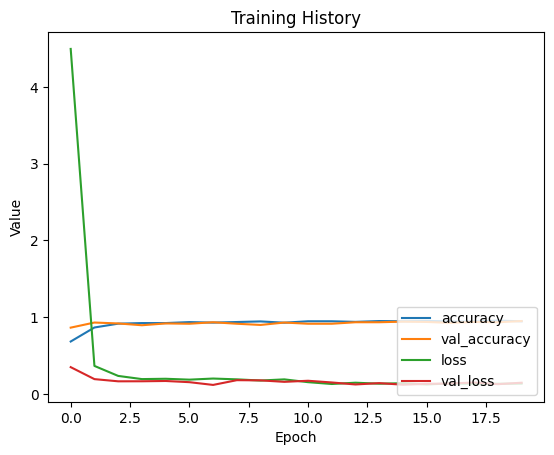

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('Training History')
plt.show()